## DATA COLLECTION


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install xgboost
!pip install imbalanced-learn

import os
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
from xgboost import plot_tree

from imblearn.over_sampling import SMOTE


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Loading the datasets

In [ ]:
#Had to make a copy of our folder called MLProjectLocal with only Datasets in it, otherwise it was saying file did not exist
#dataset_path = '/content/drive/MyDrive/MLProjectLocal/Datasets'
dataset_path = '/content/drive/MyDrive/MLProject/Datasets'
#dataset_path = '/content/drive/MyDrive/Datasets'

#List of all .csv files currently within Datasets
csv_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.csv')]

#Combining all stations
df_list = []
for file in csv_files:
    if 'station' in file:
      df_station = pd.read_csv(file)
      df_list.append(df_station)

df = pd.concat(df_list, ignore_index=True)

## BASELINE MODEL FOR PRELIM RESULTS


#### Model Development


In [ ]:
df = df.drop(columns=["id", "internal_station_id", "collected_at"])

#Drop rows where the oxygen is missing
if "dissolved_oxygen_mg/L" not in df.columns:
  print(1)
df = df.dropna(subset=["dissolved_oxygen_mg/L"])

#Define low-dissolved oxygen
df["hypoxic"] = (df["dissolved_oxygen_mg/L"] < 7).astype(int)

df = df.drop(columns=["dissolved_oxygen_mg/L"])

X = df.drop(columns=["hypoxic"])
y = df["hypoxic"]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:24:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 2000x2000 with 0 Axes>

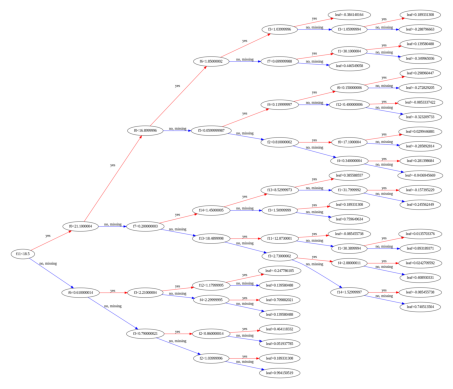

Classification Report for XGBoost
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       372
           1       0.73      0.69      0.71       125

    accuracy                           0.86       497
   macro avg       0.81      0.80      0.81       497
weighted avg       0.85      0.86      0.86       497


Holdout Test AUROC for XGBoost: 0.9176


In [ ]:
#Use mean for missing data entries
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

#Follow 80/20 split for training/testing
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, stratify=y, random_state=42)

#Train
xgb_model = XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)

plt.figure(figsize=(20,20))
plot_tree(xgb_model, rankdir='LR')
plt.show()

y_test_pred = xgb_model.predict(X_test)

print("Classification Report for XGBoost")
print(classification_report(y_test, y_test_pred))
# Predict probabilities for AUROC
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]  # Take probability for class 1

# Compute AUROC
test_auc = roc_auc_score(y_test, y_test_proba)

print(f"\nHoldout Test AUROC for XGBoost: {test_auc:.4f}")

Cross-validation

In [ ]:
#Define model
model = XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42)

#Define Stratified K-Fold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

precision_scores = []
recall_scores = []
f1_scores = []

fold = 1
for train_index, test_index in cv.split(X_imputed, y):
    X_train, X_test = X_imputed[train_index], X_imputed[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Store scores for positive class (hypoxic = 1)
    precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # print classification report
    #print(f"\nFold {fold} Classification Report:")
    #print(classification_report(y_test, y_pred))

    fold += 1

summary_df = pd.DataFrame({
    'Fold': list(range(1, 6)),
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1-Score': f1_scores
})

print("\nCross-Validation Summary:")
print(summary_df)
print("\nAverage Precision:", np.mean(precision_scores))
print("Average Recall:", np.mean(recall_scores))
print("Average F1-Score:", np.mean(f1_scores))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:24:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:24:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:24:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:24:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:24:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Cross-Validation Summary:
   Fold  Precision  Recall  F1-Score
0     1   0.733945   0.640  0.683761
1     2   0.781818   0.688  0.731915
2     3   0.841121   0.720  0.775862
3     4   0.758621   0.704  0.730290
4     5   0.778761   0.704  0.739496

Average Precision: 0.77885327657516
Average Recall: 0.6911999999999999
Average F1-Score: 0.7322647802188171


#### Logistic Regression

In [ ]:
lr_model = LogisticRegression(max_iter=5000) # max_iter set to 5000 because of convergence

lr_model.fit(X_train, y_train)

lr_expected = y_test
lr_pred = lr_model.predict(X_test)

print()
print("Classification Report for Logistic Regression")
print(classification_report(lr_expected, lr_pred))
# Predict probabilities for AUROC
lr_proba = lr_model.predict_proba(X_test)[:, 1]  # Probability for class 1

# Compute AUROC
lr_auc = roc_auc_score(lr_expected, lr_proba)

print(f"\nHoldout Test AUROC for Logistic Regression: {lr_auc:.4f}")



Classification Report for Logistic Regression
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       371
           1       0.76      0.43      0.55       125

    accuracy                           0.82       496
   macro avg       0.80      0.69      0.72       496
weighted avg       0.81      0.82      0.80       496


Holdout Test AUROC for Logistic Regression: 0.8349


#### Comparing feature relevance between models

In [ ]:
# XGBoost

#xgboost.plot_importance(model)

xgb_importance = xgb_model.get_booster().get_score(importance_type='gain')
xgb_df = pd.DataFrame({'Feature': list(xgb_importance.keys()), 'XGB_Importance': list(xgb_importance.values())})

feature_map = {f"f{i}": col for i, col in enumerate(X.columns)}
xgb_df['Feature'] = xgb_df['Feature'].map(feature_map)

top5_xgb = (
    xgb_df.sort_values(by='XGB_Importance', ascending=False)
    .head(5)
)

In [ ]:
# Logistic Regression

lr_coefficients = lr_model.coef_[0]

lr_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_coefficients
})
lr_df['Absolute_Coefficient'] = lr_df['Coefficient'].abs()

top5_lr = (
    lr_df.sort_values(by='Absolute_Coefficient', ascending=False)
    [['Feature', 'Coefficient']]
    .head(5)
)


In [ ]:
#XGBoost with cross-validation
feature_importances_list = []

for train_index, test_index in cv.split(X_imputed, y):
    X_train, X_test = X_imputed[train_index], X_imputed[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)

    booster = model.get_booster()
    fold_importance = booster.get_score(importance_type='gain')

    feature_map = {f"f{i}": col for i, col in enumerate(X.columns)}
    mapped_importance = {feature_map[k]: v for k, v in fold_importance.items()}

    feature_importances_list.append(mapped_importance)

importance_df = pd.DataFrame(feature_importances_list).fillna(0)

# Average across folds
avg_importance = importance_df.mean().reset_index()
avg_importance.columns = ['Feature', 'XGB_Importance']


top5_xgb_cv = avg_importance.sort_values(by='XGB_Importance', ascending=False).head(5)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:24:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:24:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:24:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
print("Logistic Regression")
print(top5_lr)
print()

print("XGBoost")
print(top5_xgb)
print()

print("XGBoost with Cross-Validation")
print(top5_xgb_cv)

Logistic Regression
                            Feature  Coefficient
11      total_dissolved_nitrogen_uM     0.579655
9   particulate_organic_nitrogen_uM     0.450856
15           total_nitrogen_TDN_PON    -0.447329
12    total_dissolved_phosphorus_uM     0.292239
7                ortho_phosphate_uM    -0.188870

XGBoost
                            Feature  XGB_Importance
11      total_dissolved_nitrogen_uM       12.596946
0                     temperature_C        3.212451
12    total_dissolved_phosphorus_uM        2.129850
6                       ammonium_uM        1.959396
9   particulate_organic_nitrogen_uM        1.656487

XGBoost with Cross-Validation
                            Feature  XGB_Importance
11      total_dissolved_nitrogen_uM       14.313536
0                     temperature_C        3.300815
9   particulate_organic_nitrogen_uM        1.914974
6                       ammonium_uM        1.888416
12    total_dissolved_phosphorus_uM        1.671789


#### Hyperparameter tuning


#### Implementing SMOTE

In [ ]:
#Resplitting for a new train/test split in SMOTE

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, stratify=y, random_state=42)
sm = SMOTE(random_state=42)

#Implementing SMOTE on the new training data
X_res, y_res = sm.fit_resample(X_train, y_train)

#Setting our models
smote_xgb_model = XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42)
smote_lr_model = LogisticRegression(max_iter=5000) # max_iter set to 5000 because of convergence

#Results from SMOTE
smote_xgb_model.fit(X_res, y_res)
smote_lr_model.fit(X_res, y_res)

smote_y_pred = smote_xgb_model.predict(X_test)

smote_lr_expected = y_test
smote_lr_pred = smote_lr_model.predict(X_test)

# XGBoost with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_precision = []
cv_recall = []
cv_f1 = []

for train_index, test_index in cv.split(X_imputed, y):
    X_train_fold, X_test_fold = X_imputed[train_index], X_imputed[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # SMOTE inside each fold
    sm = SMOTE(random_state=42)
    X_train_fold_res, y_train_fold_res = sm.fit_resample(X_train_fold, y_train_fold)

    smote_xgb_model_cv = XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42)
    smote_xgb_model_cv.fit(X_train_fold_res, y_train_fold_res)
    smote_y_pred_fold = smote_xgb_model_cv.predict(X_test_fold)

    cv_precision.append(precision_score(y_test_fold, smote_y_pred_fold, pos_label=1, zero_division=0))
    cv_recall.append(recall_score(y_test_fold, smote_y_pred_fold, pos_label=1, zero_division=0))
    cv_f1.append(f1_score(y_test_fold, smote_y_pred_fold, pos_label=1, zero_division=0))

print()
print("Classification Report for XGBoost")
print(classification_report(y_test, smote_y_pred))

print()
print("Classification Report for Logistic Regression")
print(classification_report(smote_lr_expected, smote_lr_pred))

print()
print("Cross-Validation Precision:", np.mean(cv_precision))
print("Cross-Validation Recall:", np.mean(cv_recall))
print("Cross-Validation F1-Score:", np.mean(cv_f1))
# Predict probabilities
smote_xgb_proba = smote_xgb_model.predict_proba(X_test)[:, 1]  # Probability for class 1
smote_lr_proba = smote_lr_model.predict_proba(X_test)[:, 1]    # Same here

# Calculate AUROC
xgb_auc = roc_auc_score(y_test, smote_xgb_proba)
lr_auc = roc_auc_score(smote_lr_expected, smote_lr_proba)

print()
print(f"AUROC for SMOTE XGBoost model: {xgb_auc:.4f}")
print(f"AUROC for SMOTE Logistic Regression model: {lr_auc:.4f}")



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:24:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:25:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:25:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:25:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:25:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Classification Report for XGBoost
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       372
           1       0.68      0.72      0.70       125

    accuracy                           0.85       497
   macro avg       0.79      0.80      0.80       497
weighted avg       0.85      0.85      0.85       497


Classification Report for Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.77      0.83       372
           1       0.51      0.73      0.60       125

    accuracy                           0.76       497
   macro avg       0.70      0.75      0.71       497
weighted avg       0.80      0.76      0.77       497


Cross-Validation Precision: 0.7094376788828993
Cross-Validation Recall: 0.7664
Cross-Validation F1-Score: 0.7366159223706308

AUROC for SMOTE XGBoost model: 0.9109
AUROC for SMOTE Logistic Regression model: 0.8240


In [ ]:

# 1. Prepare X, y
X = df.drop(columns=["hypoxic"])
y = df["hypoxic"]

# 2. Build a pipeline with imputation + classifier
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("xgb", XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        verbosity=0
    ))
])

# 3. Parameter distribution
param_dist = {
    "xgb__learning_rate":    [0.01, 0.05, 0.1, 0.2],
    "xgb__n_estimators":     [100, 200, 500, 1000],
    "xgb__max_depth":        [3, 4, 6, 8],
    "xgb__subsample":        [0.6, 0.8, 1.0],
    "xgb__colsample_bytree": [0.6, 0.8, 1.0],
    "xgb__gamma":            [0, 0.1, 0.5, 1],
    "xgb__reg_alpha":        [0, 0.1, 1, 5],
    "xgb__reg_lambda":       [1, 5, 10],
    # (optional) to help with imbalance:
    "xgb__scale_pos_weight": [1, (len(y)-y.sum())/y.sum()]
}

# 4. Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. Randomized search
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",       # or "accuracy", "f1", etc.
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 6. Fit and inspect best params
search.fit(X_imputed, y)
print("Best hyperparameters:", search.best_params_)
print("Best CV Score:", search.best_score_)

# 7. Evaluate on a hold-out test set
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, stratify=y, random_state=42
)

best_model = search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("\nClassification Report for XGBoost (with tuned hyperparams):")
print(classification_report(y_test, y_pred))
# Predict probabilities for AUROC
y_proba = best_model.predict_proba(X_test)[:, 1]  # Take probability of class 1

# Compute AUROC
test_auc = roc_auc_score(y_test, y_proba)

print(f"\nHoldout Test AUROC: {test_auc:.4f}")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'xgb__subsample': 0.8, 'xgb__scale_pos_weight': 1, 'xgb__reg_lambda': 1, 'xgb__reg_alpha': 1, 'xgb__n_estimators': 500, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.5, 'xgb__colsample_bytree': 0.8}
Best CV Score: 0.9150502275164479

Classification Report for XGBoost (with tuned hyperparams):
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       372
           1       0.72      0.58      0.65       125

    accuracy                           0.84       497
   macro avg       0.80      0.75      0.77       497
weighted avg       0.83      0.84      0.83       497


Holdout Test AUROC: 0.9211


In [ ]:

# 1. Your feature matrix and target
X = df.drop(columns=["hypoxic"])
y = df["hypoxic"]

# 2. Pipeline: Impute → SMOTE → XGBoost
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("smote", SMOTE(random_state=42)),
    ("xgb", XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        verbosity=0
    ))
])

# 3. Parameter grid (for the XGBoost step)
param_dist = {
    "xgb__learning_rate":    [0.01, 0.05, 0.1, 0.2],
    "xgb__n_estimators":     [100, 200, 500, 1000],
    "xgb__max_depth":        [3, 4, 6, 8],
    "xgb__subsample":        [0.6, 0.8, 1.0],
    "xgb__colsample_bytree": [0.6, 0.8, 1.0],
    "xgb__gamma":            [0, 0.1, 0.5, 1],
    "xgb__reg_alpha":        [0, 0.1, 1, 5],
    "xgb__reg_lambda":       [1, 5, 10],
    # You don't usually tune SMOTE inside here, but you could if you wanted to
}

# 4. Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 6. Fit
search.fit(X, y)

print("Best Hyperparameters:", search.best_params_)
print("Best CV Score:", search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Hyperparameters: {'xgb__subsample': 1.0, 'xgb__reg_lambda': 5, 'xgb__reg_alpha': 1, 'xgb__n_estimators': 1000, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.2, 'xgb__gamma': 0, 'xgb__colsample_bytree': 0.8}
Best CV Score: 0.914286409877402


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 8. Refit the best model
best_model = search.best_estimator_
best_model.fit(X_train, y_train)

# 9. Predict on the holdout test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# 10. Compute AUROC
test_auc = roc_auc_score(y_test, y_proba)

# 11. Print metrics
print("\nClassification Report for XGBoost (with tuned hyperparams):")
print(classification_report(y_test, y_pred))
print(f"Holdout Test AUROC: {test_auc:.4f}")


Classification Report for XGBoost (with tuned hyperparams):
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       372
           1       0.68      0.74      0.71       125

    accuracy                           0.85       497
   macro avg       0.80      0.81      0.80       497
weighted avg       0.85      0.85      0.85       497

Holdout Test AUROC: 0.9233


In [ ]:

# Pipeline: SMOTE + Logistic Regression
lr_pipeline = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("lr", LogisticRegression(max_iter=5000, solver='saga', random_state=42))  # saga solver supports all penalties
])

# Hyperparameter grid
param_dist_lr = {
    "lr__penalty": ["l1", "l2", "elasticnet"],
    "lr__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "lr__l1_ratio": [0, 0.25, 0.5, 0.75, 1.0]  # Only used if penalty = elasticnet
}
# Cross-validation folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
search_lr = RandomizedSearchCV(
    estimator=lr_pipeline,
    param_distributions=param_dist_lr,
    n_iter=30,
    scoring="roc_auc",
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42
)
# Train RandomizedSearchCV on original X_train/y_train (before SMOTE!)
#search_lr.fit(X_train, y_train)
search_lr.fit(X_imputed, y)

print("Best hyperparameters for Logistic Regression:", search_lr.best_params_)
print("Best CV AUROC:", search_lr.best_score_)
# Predict on X_test
lr_best_model = search_lr.best_estimator_
lr_pred = lr_best_model.predict(X_test)
lr_proba = lr_best_model.predict_proba(X_test)[:, 1]

# Evaluate
print("\nClassification Report for Tuned Logistic Regression")
print(classification_report(y_test, lr_pred))

lr_auc = roc_auc_score(y_test, lr_proba)
print(f"Holdout Test AUROC for Tuned Logistic Regression: {lr_auc:.4f}")


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Best hyperparameters for Logistic Regression: {'lr__penalty': 'l2', 'lr__l1_ratio': 0.75, 'lr__C': 1}
Best CV AUROC: 0.8271182216039186


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values